## Demo notebook for accessing MoBI data on Azure

This notebook provides an example of accessing MoBI (Map of Biodiversity Importance) data from blob storage on Azure.

MoBI data are stored in the West Europe Azure region, so this notebook will run most efficiently on Azure compute located in West Europe.  We recommend that substantial computation depending on MoBI data also be situated in West Europe.  If you are using NLCD data for conservation applications, consider applying for an [AI for Earth grant](http://aka.ms/ai4egrants) to support your compute requirements.

### Imports

In [5]:
import os
from azure.storage.blob import ContainerClient

### Constants

In [9]:
sas_file = os.path.expanduser('~/tokens/mobi_sas.txt')

layer_types = ['SpeciesRichness','RSR','PWRSR_GAP12_SUM']
taxonomic_groupings = ['All','AquaticInverts','Plants','PollinatorInverts','Vertebrates']

### Azure storage constants

In [13]:
assert os.path.isfile(sas_file)
lines = []
with open(sas_file,'r') as f:
    lines = f.readlines()
assert len(lines) >= 1
sas_token = lines[0].strip()
        
storage_account_name = 'ai4edataeuwest'
container_name = 'mobi'
storage_account_url = 'https://' + storage_account_name + '.blob.core.windows.net/'

container_client = ContainerClient(account_url=storage_account_url, 
                                                 container_name=container_name,
                                                 credential=sas_token)

### View all the available layer files

In [15]:
generator = container_client.list_blobs(name_starts_with='spatial_data/')
image_paths = [blob.name for blob in generator if blob.name.endswith('.tif')]

print('Found {} layers:\n'.format(len(image_paths)))
for fn in image_paths:
    print(fn.split('/')[-1])

Found 14 layers:

PWRSR_GAP12_SUM_All.tif
PWRSR_GAP12_SUM_AquaticInverts.tif
PWRSR_GAP12_SUM_Plants.tif
PWRSR_GAP12_SUM_PollinatorInverts.tif
PWRSR_GAP12_SUM_Vertebrates.tif
RSR_All.tif
RSR_AquaticInverts.tif
RSR_Plants.tif
RSR_Vertebrates.tif
SpeciesRichness_All.tif
SpeciesRichness_AquaticInverts.tif
SpeciesRichness_Plants.tif
SpeciesRichness_PollinatorInverts.tif
SpeciesRichness_Vertebrates.tif


### Load data for a single year

In [32]:
url = f'https://{account_name}.blob.core.windows.net/' + \
                      f'{container}/raw/nlcd/{area}/30m/{year}.tif'
da = xr.open_rasterio(url,chunks=dict(x=2560, y=2560))
print(url)

# Transform our data array to dataset by selecting the only data variable ('band'), and
# rename it to something useful ('landcover')
ds = da.to_dataset(dim='band').rename({1: 'landcover'})
ds

https://cpdataeuwest.blob.core.windows.net/cpdata/raw/nlcd/conus/30m/2001.tif


<xarray.Dataset>
Dimensions:    (x: 161190, y: 104424)
Coordinates:
  * y          (y) float64 3.31e+06 3.31e+06 3.31e+06 ... 1.773e+05 1.773e+05
  * x          (x) float64 -2.493e+06 -2.493e+06 ... 2.343e+06 2.343e+06
Data variables:
    landcover  (y, x) uint8 dask.array<chunksize=(2560, 2560), meta=np.ndarray>
Attributes:
    transform:           (30.0, 0.0, -2493045.0, 0.0, -30.0, 3310005.0)
    crs:                 +proj=aea +lat_0=23 +lon_0=-96 +lat_1=29.5 +lat_2=45...
    res:                 (30.0, 30.0)
    is_tiled:            1
    nodatavals:          (nan,)
    scales:              (1.0,)
    offsets:             (0.0,)
    descriptions:        ('Layer_1',)
    AREA_OR_POINT:       Area
    OVR_RESAMPLING_ALG:  NEAREST

### Load and downsample forest cover data

In [4]:
# Let's look at forest lands in the U.S. 
#
# Land cover data are stored as categorical variables, and the legend for the code
# can be found in: 
#
# https://www.mrlc.gov/data/legends/national-land-cover-database-2016-nlcd2016-legend
#
# Forest lands correspond to codes 41, 42, and 43.

deciduous = ds.landcover.isin([41]).astype(int)
evergreen = ds.landcover.isin([42]).astype(int)
mixed     = ds.landcover.isin([43]).astype(int)

# Coarsen by 100x on each dimension to get to a reasonable plotting size 
factor = 100
deciduous = deciduous.coarsen(dim={'x': factor, 'y': factor}, boundary='trim').mean().compute()
evergreen = evergreen.coarsen(dim={'x': factor, 'y': factor}, boundary='trim').mean().compute()
mixed = mixed.coarsen(dim={'x': factor, 'y': factor}, boundary='trim').mean().compute()

In [15]:
mixed

<xarray.DataArray (y: 1044, x: 1611)>
array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])
Coordinates:
  * y        (y) float64 3.309e+06 3.306e+06 3.303e+06 ... 1.825e+05 1.795e+05
  * x        (x) float64 -2.492e+06 -2.489e+06 ... 2.335e+06 2.338e+06

### Plot forest distributions over CONUS

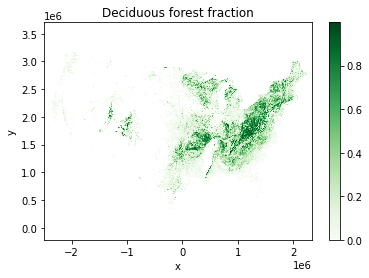

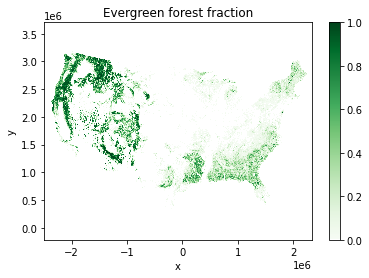

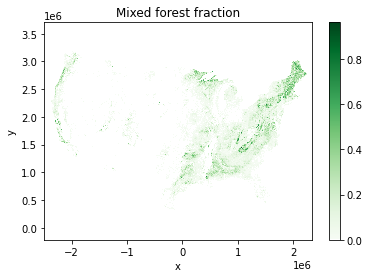

In [29]:
# Create a custom colormap that makes zeros white
import matplotlib
from matplotlib import cm
cmap = cm.get_cmap('Greens')
cmaplist = [cmap(i) for i in range(cmap.N)]
cmaplist[0] = (1.0,1.0,1.0,1.0)
cmap = matplotlib.colors.LinearSegmentedColormap.from_list('mcm',cmaplist, cmap.N)

deciduous.plot(cmap=cmap)
plt.title('Deciduous forest fraction')
plt.axis('equal')
plt.show()

evergreen.plot(cmap=cmap)
plt.title('Evergreen forest fraction')
plt.axis('equal')
plt.show()

mixed.plot(cmap=cmap)
plt.title('Mixed forest fraction')
plt.axis('equal')
plt.show()

### Plot an overview of nationwide land cover

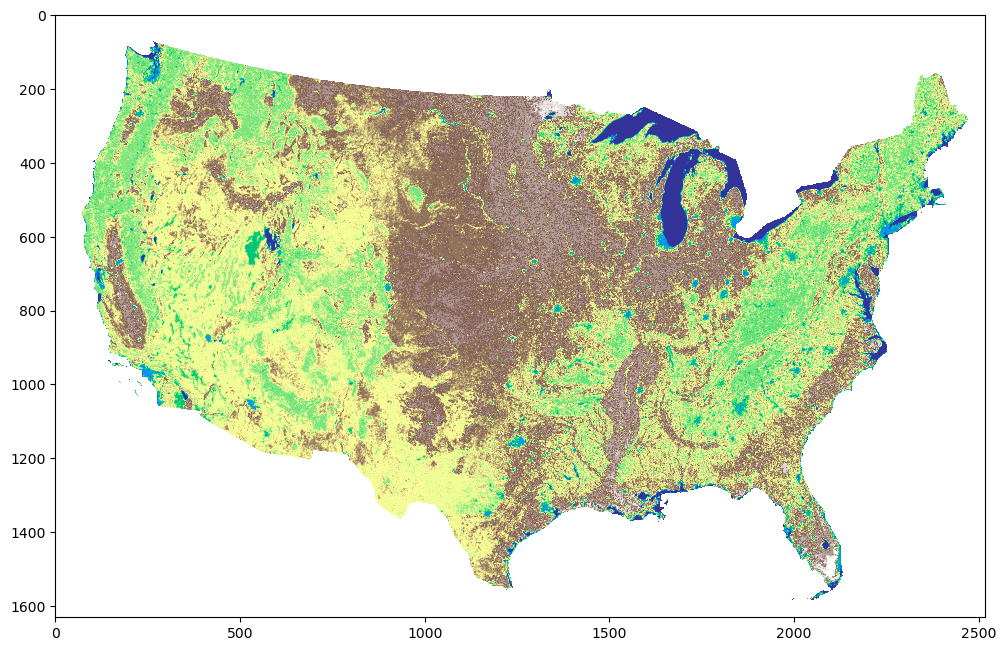

In [60]:
# With help from:
#
# https://automating-gis-processes.github.io/CSC/notebooks/L5/read-cogs.html

import rasterio
fp = url
with rasterio.open(fp) as src:
    
    # List of overviews from biggest to smallest
    oviews = src.overviews(1)

    # Retrieve one of the thumbnails without reading the COG
    oview = oviews[-3]
    thumbnail = src.read(1, out_shape=(1, int(src.height // oview), int(src.width // oview)))
    
    # Convert 0 values to NaNs
    thumbnail = thumbnail.astype('f4')
    thumbnail[thumbnail==0] = np.nan

cmap = 'terrain'
fig=plt.figure(figsize=(12,8), dpi= 100, facecolor='w', edgecolor='k')
plt.imshow(thumbnail,cmap=cmap)